In [14]:
# Imports
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import requests
import xml.etree.ElementTree as ET
import zipfile
import io
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from sklearn.cluster import KMeans

In [15]:
# Pull public data from S3 bucket
# Base URL for Citi Bike S3 bucket
index_url = 'https://s3.amazonaws.com/tripdata/'
response = requests.get(index_url)
root = ET.fromstring(response.content)

# Parse the S3 XML to get all .csv.zip file names
namespace = {'s3': 'http://s3.amazonaws.com/doc/2006-03-01/'}
zip_files = [
    elem.find('s3:Key', namespace).text
    for elem in root.findall('s3:Contents', namespace)
    if elem.find('s3:Key', namespace).text.endswith('.zip')
]

# print(f"Total ZIP files: {len(zip_files)}")

# Split the files into 3 batches
#batch1_files = [f for f in zip_files if f.startswith(tuple(str(y) for y in range(2013, 2024)))]
batch2_files = [f for f in zip_files if f.startswith(tuple(f"{y}{m:02d}" for y in range(2024, 2026) for m in range(1, 13)))]
#batch3_files = [f for f in zip_files if f.startswith('JC-')]


In [16]:
# Create list of files from 2024 and 2025
# The following code chunks will only work with batch 2, which aligns with
# monthly data for all of 2024 and January to June of 2025.
files_2024_2025 = []
for filename in batch2_files:
    if filename.startswith('2024') or filename.startswith('2025'):
        files_2024_2025.append(filename)

In [17]:
# This code chunk was generated by Google Gemini for memory efficient
# data processing. This code downloads and processes zipped CSV files for
# 2024 and 2025 Citi Bike data in memory-efficient chunks and selects only
# essential columns. It then combines these chunks into a single DataFrame for
# further analysis and visualization. This allows for more memory efficient
# processing to avoid going over the free-tier Google Colab RAM limit.

# Initialize empty list to store chunks of data
chunks_list = []

# Iterate through files in files_2024_2025
for filename in files_2024_2025:
    file_url = f"{index_url}{filename}"
    # print(f"Processing {filename}...")

    try:
        # Download the zip file
        response = requests.get(file_url)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Use BytesIO to handle the zip file content in memory
        with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
            # Assuming there is only one CSV file in the zip
            csv_files = [f for f in zf.namelist() if f.endswith('.csv')]

            if not csv_files:
                print(f"No CSV file found in {filename}. Skipping.")
                continue

            csv_filename = csv_files[0]

            # Read the CSV file in chunks
            with zf.open(csv_filename) as csvfile:
                # Decode bytes to string for pandas to read
                csv_content = io.StringIO(csvfile.read().decode('utf-8'))
                chunk_iterator = pd.read_csv(csv_content, chunksize=50000) # Define chunk size

                # Process each chunk
                for chunk in chunk_iterator:
                    # Select only the columns needed for visualization and cluster analysis
                    relevant_cols = []
                    if 'start_lat' in chunk.columns:
                        relevant_cols.append('start_lat')
                    if 'start_lng' in chunk.columns:
                        relevant_cols.append('start_lng')
                    if 'end_lat' in chunk.columns:
                        relevant_cols.append('end_lat')
                    if 'end_lng' in chunk.columns:
                        relevant_cols.append('end_lng')
                    if 'started_at' in chunk.columns:
                         relevant_cols.append('started_at')
                    if 'ended_at' in chunk.columns:
                         relevant_cols.append('ended_at')


                    if relevant_cols:
                        chunks_list.append(chunk[relevant_cols])
                    else:
                        print(f"Warning: No relevant columns found in chunk from {filename}")


    except requests.exceptions.RequestException as e:
        print(f"Error downloading {filename}: {e}")
    except zipfile.BadZipFile:
        print(f"Error processing {filename}: Not a valid zip file.")
    except Exception as e:
        print(f"An unexpected error occurred while processing {filename}: {e}")

# Concatenate the list of chunks into a single pandas DataFrame
if chunks_list:
    df_2024_2025 = pd.concat(chunks_list, ignore_index=True)
else:
    print("No data loaded from specified files.")

In [18]:
# Data cleaning to prepare for visualization
# Convert 'started_at' and 'ended_at' to datetime objects
df_2024_2025['started_at'] = pd.to_datetime(df_2024_2025['started_at'])
df_2024_2025['ended_at'] = pd.to_datetime(df_2024_2025['ended_at'])

# ~~~~~~~~~~
# For trips by time of day
# Extract the hour of the day
df_2024_2025['start_hour'] = df_2024_2025['started_at'].dt.hour

# ~~~~~~~~~~
# For trip duration in minutes
# Calculate trip duration in minutes, handle negative durations
df_2024_2025['trip_duration_minutes'] = (df_2024_2025['ended_at'] - df_2024_2025['started_at']).dt.total_seconds() / 60
df_2024_2025['trip_duration_minutes'] = df_2024_2025['trip_duration_minutes'].clip(lower=0) # Replace negative values with 0

# ~~~~~~~~~~
# For trips by day of week
# Extract the day of the week
df_2024_2025['start_day_of_week'] = df_2024_2025['started_at'].dt.dayofweek # Monday=0, Sunday=6

# ~~~~~~~~~~
# For average trips by month
# Extract month, year, and day of the year
df_2024_2025['start_month'] = df_2024_2025['started_at'].dt.month
df_2024_2025['start_year'] = df_2024_2025['started_at'].dt.year
df_2024_2025['start_day_of_year'] = df_2024_2025['started_at'].dt.dayofyear

# Aggregate data by year and month
rides_by_year_month = df_2024_2025.groupby(['start_year', 'start_month']).size().reset_index(name='ride_count')

# Calculate average rides per month across the years
average_rides_by_month = rides_by_year_month.groupby('start_month')['ride_count'].mean().reset_index()
# ~~~~~~~~~~

# Create sample for visualizations
if len(df_2024_2025) > 1000000: # If more than 1 million rows, sample
    df_viz_sample = df_2024_2025.sample(frac=0.1, random_state=42) # Sample 10%
else:
    df_viz_sample = df_2024_2025.copy() # Otherwise, use the whole dataset

# print("\nSampled df for visualization:")
# display(df_viz_sample.head())
# print(f"\nShape of the sample df: {df_viz_sample.shape}")


# Aggregate data by 'start_hour' and 'start_day_of_week'
rides_by_hour = df_2024_2025['start_hour'].value_counts().sort_index().reset_index()
rides_by_hour.columns = ['start_hour', 'ride_count']

rides_by_day = df_2024_2025['start_day_of_week'].value_counts().sort_index().reset_index()
rides_by_day.columns = ['start_day_of_week', 'ride_count']

# print("\nOverall rides by hour:")
# display(rides_by_hour.head())

# print("\nOverall rides by day of week:")
# display(rides_by_day.head())

/tmp/ipython-input-803361364.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='start_month', y='ride_count', data=average_rides_by_month, palette='viridis')


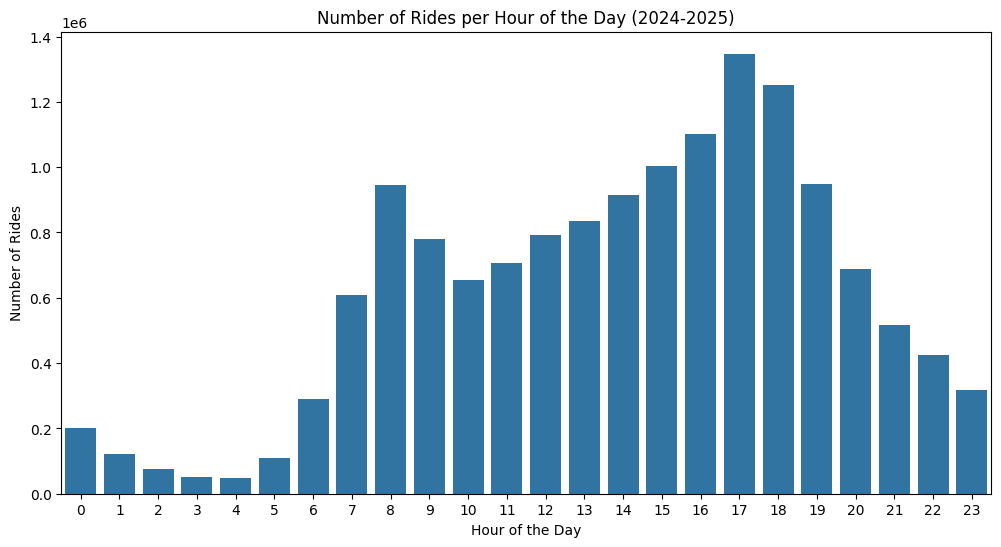

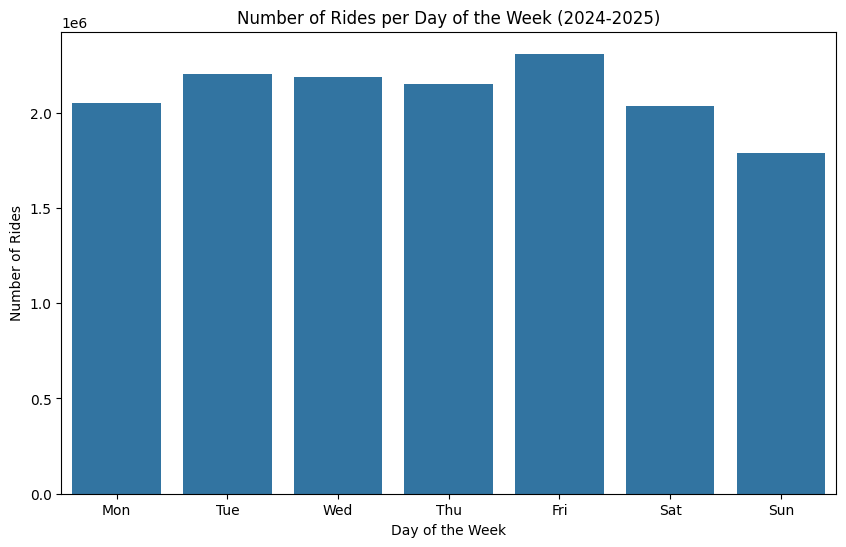

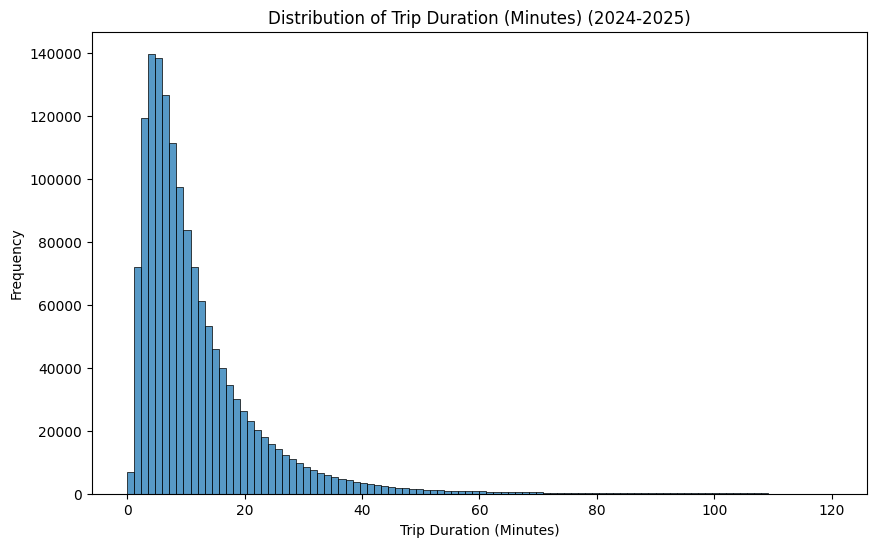

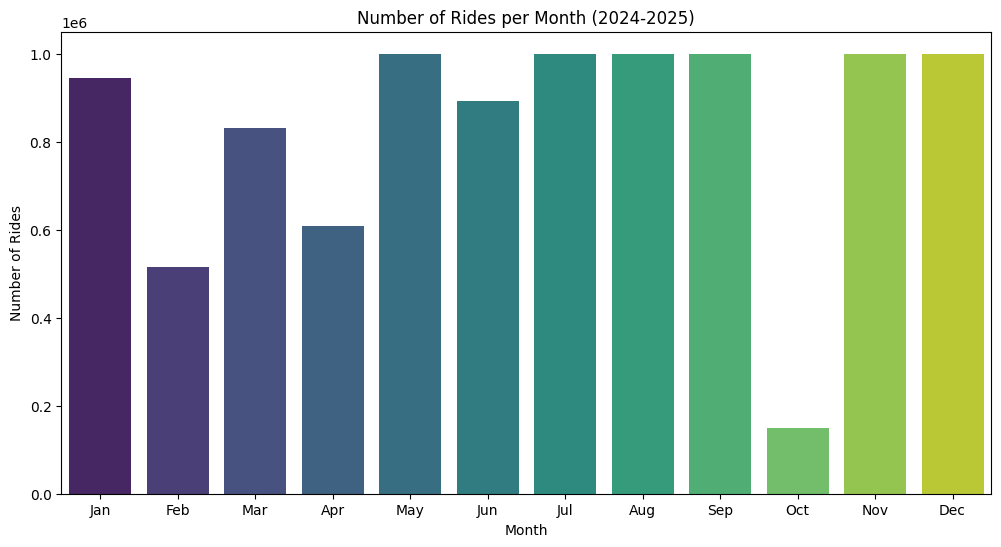

In [19]:
# EDA Visualizations
# Fig. 1 - Number of Rides by Hour of Day
plt.figure(figsize=(12, 6))
sns.barplot(x='start_hour', y='ride_count', data=rides_by_hour)
plt.title('Number of Rides per Hour of the Day (2024-2025)')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Rides')
plt.xticks(range(0, 24))

# Fig. 2 - Number of Rides by Day of Week
plt.figure(figsize=(10, 6))
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.barplot(x='start_day_of_week', y='ride_count', data=rides_by_day)
plt.title('Number of Rides per Day of the Week (2024-2025)')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rides')
plt.xticks(ticks=range(7), labels=day_labels)

# Fig. 3 - Distribution of Trip Duration in Minutes
plt.figure(figsize=(10, 6))
sns.histplot(data=df_viz_sample, x='trip_duration_minutes', bins=100, binrange=(0, 120))
plt.title('Distribution of Trip Duration (Minutes) (2024-2025)')
plt.xlabel('Trip Duration (Minutes)')
plt.ylabel('Frequency')

# Fig. 4 - Plotting rides by month
plt.figure(figsize=(12, 6))
ax1 = sns.barplot(x='start_month', y='ride_count', data=average_rides_by_month, palette='viridis')
plt.title('Number of Rides per Month (2024-2025)')
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.show()

In [20]:
# Prepare data for cluster analysis
# Select geolocation columns
geo_cols = ['start_lat', 'start_lng', 'end_lat', 'end_lng']
df_geo = df_2024_2025[geo_cols].copy()

# Handle rows with missing values
df_geo.dropna(inplace=True)

# Create 5% sample for clustering
sample_fraction = 0.05

if len(df_geo) > 100000: # Only sample if the dataset is large
    df_geo_sample = df_geo.sample(frac=sample_fraction, random_state=42)
else:
    df_geo_sample = df_geo.copy()

In [21]:
# Use sampled data from previous chunk for clustering
# Select the relevant columns for clustering
X = df_geo_sample[['start_lat', 'start_lng', 'end_lat', 'end_lng']]

# Initialize and fit KMeans model with 6 clusters
# Down to 5 clusters after removing Cluster 1 for visualization
kmeans = KMeans(n_clusters=6, random_state=42, n_init=10)
kmeans.fit(X)

# Get cluster labels and store them in new column
df_geo_sample['cluster'] = kmeans.labels_

# Display count of points in each cluster
print("\nCluster distribution:")
display(df_geo_sample['cluster'].value_counts().sort_index())


Cluster distribution:


,count
cluster,
0,169145
1,2
2,98385
3,55631
4,130194
5,281518


/tmp/ipython-input-3606056140.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base_colormap = cm.get_cmap('tab10', num_clusters_filtered)


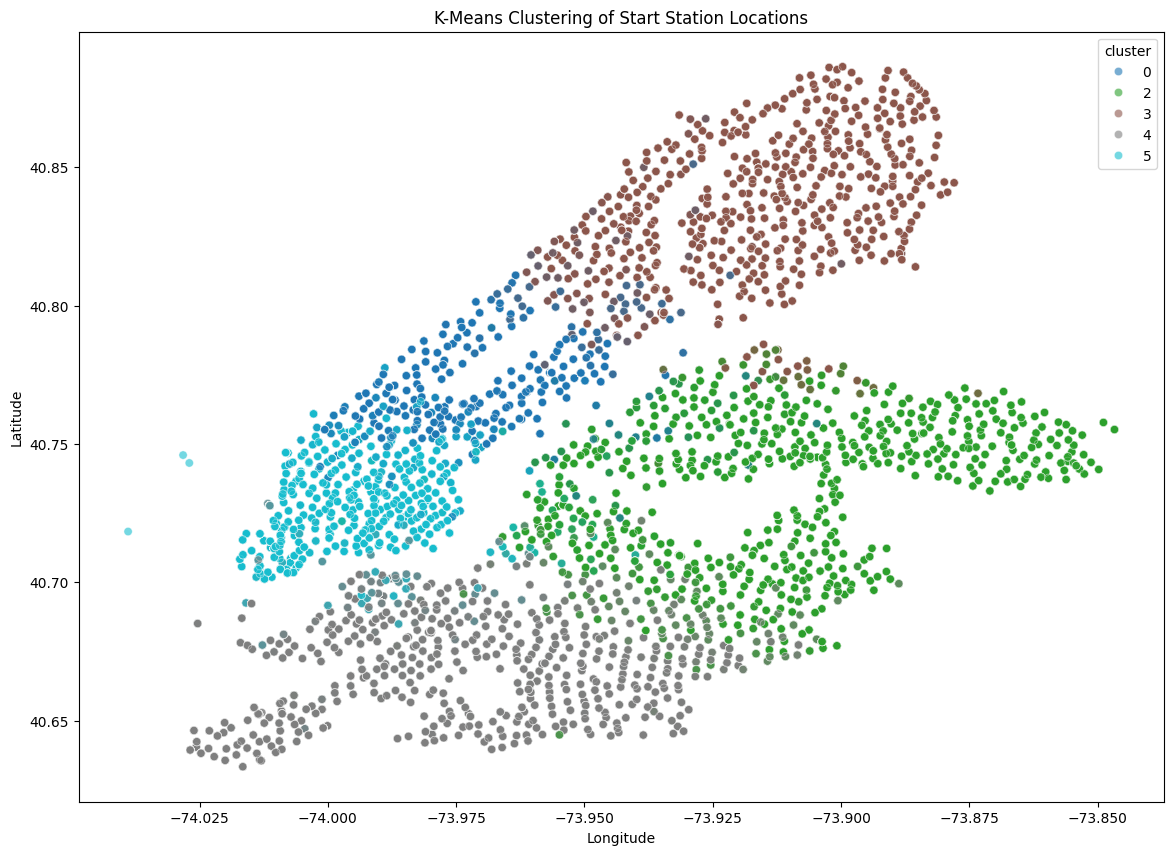

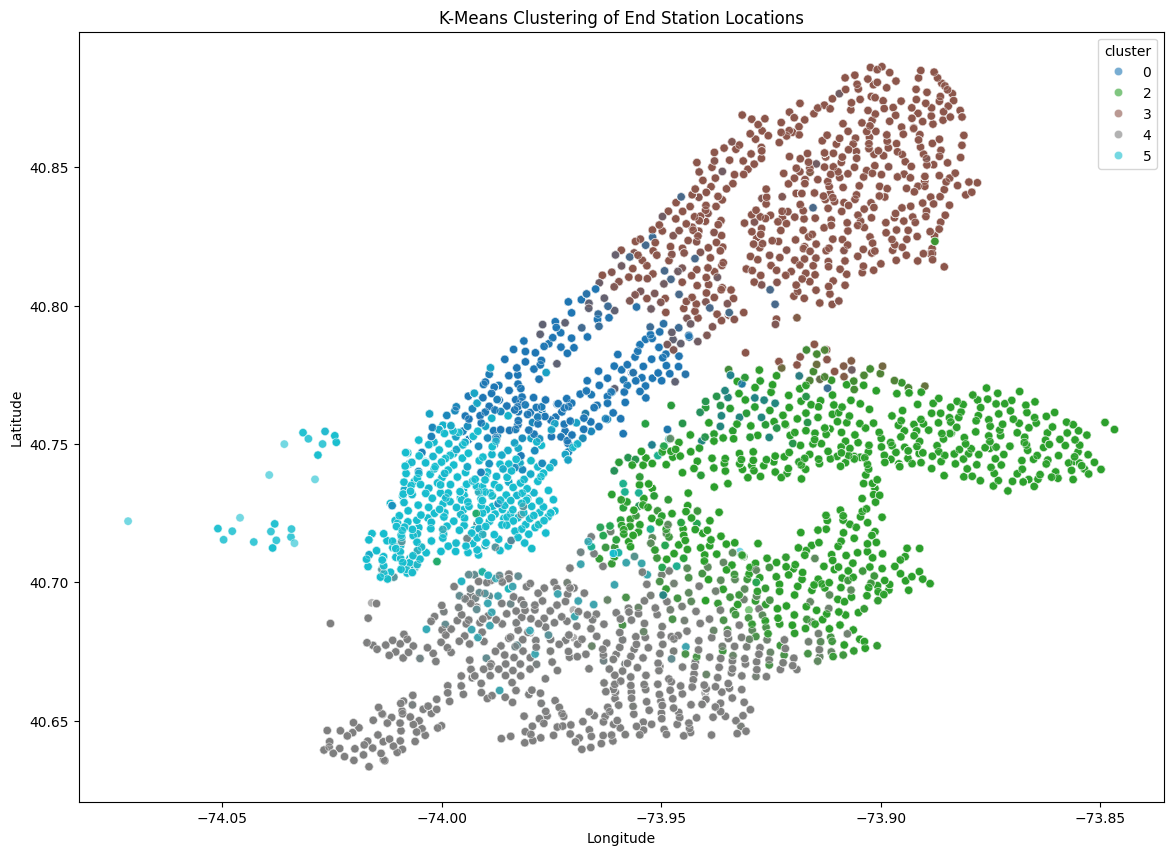

In [22]:
# Visualize clusters generated by KMeans
# Filter out rows with invalid end locations (lat or lng is 0.0)
# This will be Cluster 1
df_geo_sample_filtered = df_geo_sample[(df_geo_sample['end_lat'] != 0.0) & (df_geo_sample['end_lng'] != 0.0)].copy()

# Define a custom palette using distinct colors for the clusters
# Calculate the unique clusters present in the filtered data
unique_clusters_filtered = sorted(df_geo_sample_filtered['cluster'].unique())
num_clusters_filtered = len(unique_clusters_filtered)

# Choose an appropriate colormap for the number of clusters
base_colormap = cm.get_cmap('tab10', num_clusters_filtered)

# Create list of colors from the colormap for plotting
custom_palette = [mcolors.to_hex(base_colormap(i)) for i in range(num_clusters_filtered)]

# Explicitly convert 'cluster' to categorical type for plotting
df_geo_sample_filtered['cluster'] = df_geo_sample_filtered['cluster'].astype('category')

# Fig. 6 - Start Station Locations Colored by Cluster
plt.figure(figsize=(14, 10))
sns.scatterplot(data=df_geo_sample_filtered, x='start_lng', y='start_lat', hue='cluster', alpha=0.6, palette=custom_palette, legend='full')
plt.title('K-Means Clustering of Start Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Fig. 7 - End Station Locations Colored by Cluster
plt.figure(figsize=(14, 10))
sns.scatterplot(data=df_geo_sample_filtered, x='end_lng', y='end_lat', hue='cluster', alpha=0.6, palette=custom_palette, legend='full')
plt.title('K-Means Clustering of End Station Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()